In [18]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# Parameters
# ==============================

T = 1.0
N_t = 20
dt = T / N_t

S0 = 100.0
K = 100.0
sigma = 0.2
alpha = 0.05
r = 0.03
lambda_tc = 0.01  # transaction cost rate

gamma = 0.5

u = np.exp(sigma * np.sqrt(dt))
d = np.exp(-sigma * np.sqrt(dt))
p = (np.exp(alpha * dt) - d) / (u - d)

# ==============================
# Grids for W and y
# ==============================

W_min, W_max = 1.0, 200.0
N_W = 400
W_grid = np.linspace(W_min, W_max, N_W)

Delta_y = 1.0
M = 5
y_grid = np.arange(-M, M+1)
N_y = len(y_grid)

# ==============================
# Utility function
# ==============================

def utility(x):
    return x**gamma / gamma if x > 0 else -1e10

def interp(U_array, W_new):
    return np.interp(W_new, W_grid, U_array)

In [20]:
# ==============================
# Initialize value function dictionary
# Keys: (n, i) for time n and i up moves
# Values: 2D array U[y_index, W_index]
# ==============================

U_no_opt = {}

# ==============================
# Terminal condition at T
# ==============================

for i in range(N_t + 1):
    S_val = S0 * (u ** i) * (d ** (N_t - i))
    U_no_opt[(N_t, i)] = np.zeros((N_y, N_W))
    for k, y in enumerate(y_grid):
        for j, W in enumerate(W_grid):
            liquidation = W + S_val * y - lambda_tc * S_val * abs(y)
            U_no_opt[(N_t, i)][k, j] = utility(liquidation)

# ==============================
# Backward recursion
# ==============================

for n in reversed(range(N_t)):
    for i in range(n + 1):
        S_val = S0 * (u ** i) * (d ** (n - i))
        U_val = np.full((N_y, N_W), -1e10)

        for k, y in enumerate(y_grid):
            for j, W in enumerate(W_grid):

                # --- No Transaction ---
                W_nt = W * np.exp(r * dt)
                j_nt = np.argmin(np.abs(W_grid - W_nt))
                val_up = U_no_opt[(n+1, i+1)][k, j_nt]
                val_down = U_no_opt[(n+1, i)][k, j_nt]
                val_nt = p * val_up + (1 - p) * val_down

                # --- Buy ---
                if k < N_y - 1:
                    W_buy = W - (1 + lambda_tc) * S_val * Delta_y
                    W_buy *= np.exp(r * dt)
                    if W_buy >= W_min:
                        j_b = np.argmin(np.abs(W_grid - W_buy))
                        val_buy_up = U_no_opt[(n+1, i+1)][k+1, j_b]
                        val_buy_down = U_no_opt[(n+1, i)][k+1, j_b]
                        val_buy = p * val_buy_up + (1 - p) * val_buy_down
                    else:
                        val_buy = -1e10
                else:
                    val_buy = -1e10

                # --- Sell ---
                if k > 0:
                    W_sell = W + (1 - lambda_tc) * S_val * Delta_y
                    W_sell *= np.exp(r * dt)
                    if W_sell <= W_max:
                        j_s = np.argmin(np.abs(W_grid - W_sell))
                        val_sell_up = U_no_opt[(n+1, i+1)][k-1, j_s]
                        val_sell_down = U_no_opt[(n+1, i)][k-1, j_s]
                        val_sell = p * val_sell_up + (1 - p) * val_sell_down
                    else:
                        val_sell = -1e10
                else:
                    val_sell = -1e10

                # Take max
                U_val[k, j] = max(val_nt, val_buy, val_sell)

        U_no_opt[(n, i)] = U_val


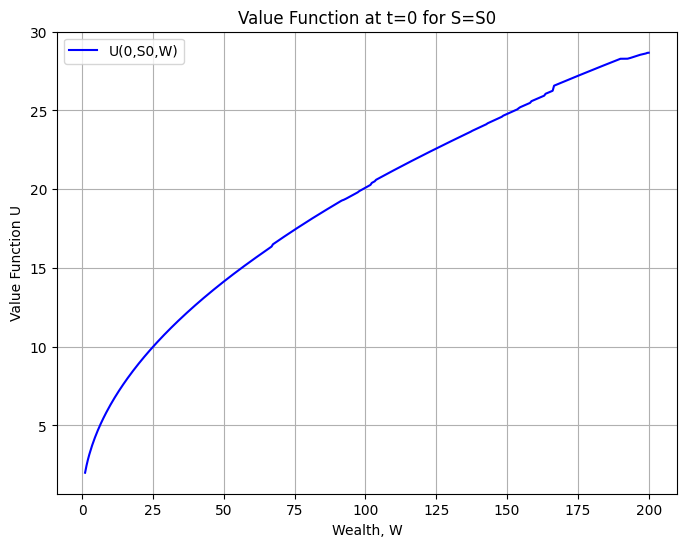

In [21]:
# ==============================
# Display / Plot the result
# ==============================
# For example, plot U(0,S0,W) vs. W at the root node (time 0, index 0).
plt.figure(figsize=(8,6))
plt.plot(W_grid, U_no_opt[(0, 0)][N_y//2,:], 'b-', label="U(0,S0,W)")
plt.xlabel("Wealth, W")
plt.ylabel("Value Function U")
plt.title("Value Function at t=0 for S=S0")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# ==============================
# Initialize value function dictionary
# Keys: (n, i) for time n and i up moves
# Values: 2D array U[y_index, W_index]
# ==============================

U = {}

# ==============================
# Terminal condition at T
# ==============================

for i in range(N_t + 1):
    S_val = S0 * (u ** i) * (d ** (N_t - i))
    U[(N_t, i)] = np.zeros((N_y, N_W))
    for k, y in enumerate(y_grid):
        for j, W in enumerate(W_grid):
            option_payoff = max(S_val - K, 0)
            liquidation = max(W + S_val * y - lambda_tc * S_val * abs(y) - option_payoff, 1e-8)
            U[(N_t, i)][k, j] = utility(liquidation)

# ==============================
# Backward recursion
# ==============================

for n in reversed(range(N_t)):
    for i in range(n + 1):
        S_val = S0 * (u ** i) * (d ** (n - i))
        U_val = np.full((N_y, N_W), -1e10)

        for k, y in enumerate(y_grid):
            for j, W in enumerate(W_grid):

                # --- No Transaction ---
                W_nt = W * np.exp(r * dt)
                j_nt = np.argmin(np.abs(W_grid - W_nt))
                val_up = U[(n+1, i+1)][k, j_nt]
                val_down = U[(n+1, i)][k, j_nt]
                val_nt = p * val_up + (1 - p) * val_down

                # --- Buy ---
                if k < N_y - 1:
                    W_buy = W - (1 + lambda_tc) * S_val * Delta_y
                    W_buy *= np.exp(r * dt)
                    if W_buy >= W_min:
                        j_b = np.argmin(np.abs(W_grid - W_buy))
                        val_buy_up = U[(n+1, i+1)][k+1, j_b]
                        val_buy_down = U[(n+1, i)][k+1, j_b]
                        val_buy = p * val_buy_up + (1 - p) * val_buy_down
                    else:
                        val_buy = -1e10
                else:
                    val_buy = -1e10

                # --- Sell ---
                if k > 0:
                    W_sell = W + (1 - lambda_tc) * S_val * Delta_y
                    W_sell *= np.exp(r * dt)
                    if W_sell <= W_max:
                        j_s = np.argmin(np.abs(W_grid - W_sell))
                        val_sell_up = U[(n+1, i+1)][k-1, j_s]
                        val_sell_down = U[(n+1, i)][k-1, j_s]
                        val_sell = p * val_sell_up + (1 - p) * val_sell_down
                    else:
                        val_sell = -1e10
                else:
                    val_sell = -1e10

                # Take max
                U_val[k, j] = max(val_nt, val_buy, val_sell)

        U[(n, i)] = U_val


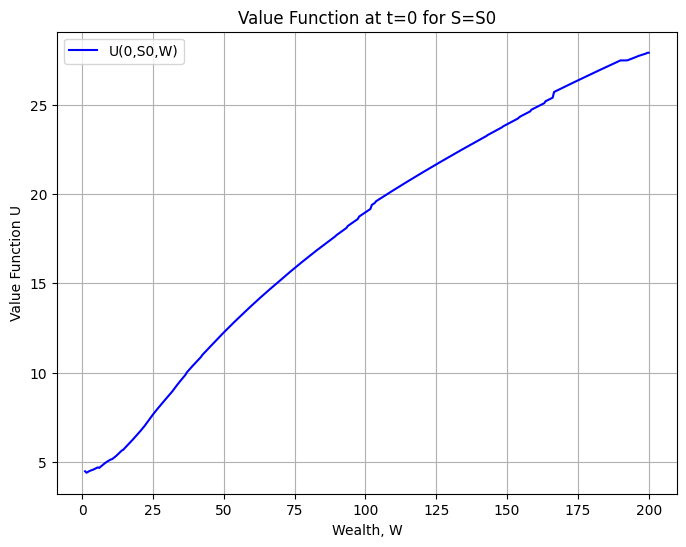

In [ ]:
# ==============================
# Display / Plot the result
# ==============================
# For example, plot U(0,S0,W) vs. W at the root node (time 0, index 0).
plt.figure(figsize=(8,6))
plt.plot(W_grid, U[(0, 0)][N_y//2,:], 'b-', label=r"$U(0,S_0,W+C)$")
plt.xlabel("Wealth, W")
plt.ylabel("Value Function U")
plt.title("Value Function at t=0 for S=S0")
plt.legend()
plt.grid(True)
plt.show()


In [26]:
from scipy.optimize import minimize_scalar
import numpy as np

def f(C):
    W_shifted = W_grid + C
    U_shifted = np.interp(W_shifted, W_grid, U[(0, 0)][N_y//2,:])
    error = np.sqrt(np.mean((U_shifted - U_no_opt[(0, 0)][N_y//2,:])**2))
    return error

res = minimize_scalar(f, bounds=(0, 20), method='bounded')
C_optimal = res.x
print("Optimal C =", C_optimal)


Optimal C = 10.549338635844068


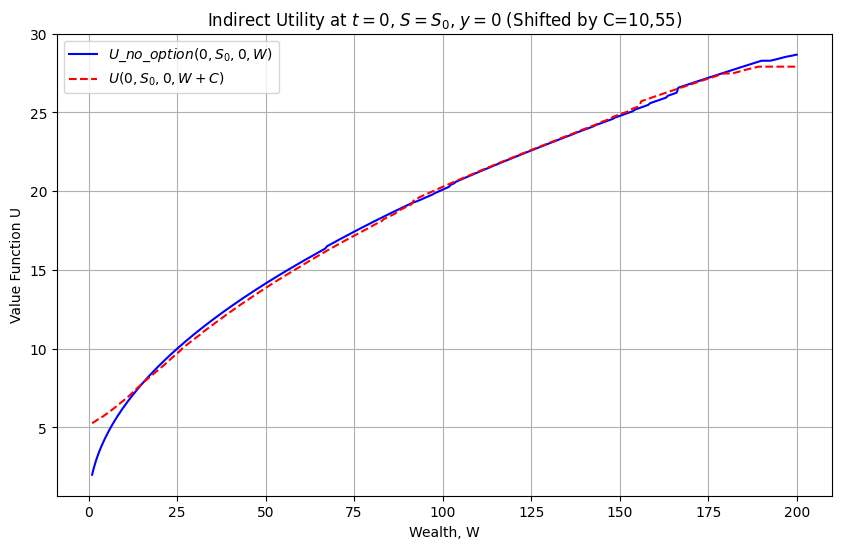

In [31]:
# Define the price shift C (e.g., the call premium)
C = C_optimal 

# Create a shifted wealth grid
W_shifted = W_grid + C

# Use linear interpolation to evaluate U(0, S0, W+C)
U_shifted = np.interp(W_shifted, W_grid, U[(0, 0)][N_y//2, :])

plt.figure(figsize=(10,6))
plt.plot(W_grid, U_no_opt[(0,0)][N_y//2,:], 'b-', label=r'$U\_no\_option(0,S_0,0,W)$')
plt.plot(W_grid, U_shifted, 'r--', label=r"$U(0,S_0,0,W+C)$")
plt.xlabel("Wealth, W")
plt.ylabel("Value Function U")
plt.title("Indirect Utility at $t=0$, $S=S_0$, $y=0$ (Shifted by C=10,55)")
plt.legend()
plt.grid(True)
plt.show()
